<a href="https://colab.research.google.com/github/firenzeey/Monkey_Pox_Detection/blob/main/monkeypox_classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyngrok
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 4.1 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=6a1b5be756e29e448465f05eb2c5a4e4d724363ae05f817906517e42f7ad7b56
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from flask import Flask, render_template, request, redirect
import os
import imageio as iio
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
ngrok.set_auth_token("2IShqpIP6mJnn5HWTqjtYyMeXPp_NJdNFeMgQTH2mnj8Jwyf")
import os

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
import base64
import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Monkeypox-cse499/Fold1/Train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Monkeypox', 'Others']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available()
                                  else "cpu")
model = models.vgg16(pretrained=True)
print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Pre-train

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(25088, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, '/content/drive/MyDrive/Monkeypox-cse499/monkeypox_vgg16.pth')

Epoch 1/10.. Train loss: 4.637.. Test loss: 2.247.. Test accuracy: 0.691
Epoch 1/10.. Train loss: 1.687.. Test loss: 1.329.. Test accuracy: 0.744
Epoch 2/10.. Train loss: 0.828.. Test loss: 0.474.. Test accuracy: 0.834
Epoch 2/10.. Train loss: 0.261.. Test loss: 0.294.. Test accuracy: 0.879
Epoch 2/10.. Train loss: 0.188.. Test loss: 0.280.. Test accuracy: 0.871
Epoch 3/10.. Train loss: 0.150.. Test loss: 0.262.. Test accuracy: 0.889
Epoch 3/10.. Train loss: 0.144.. Test loss: 0.247.. Test accuracy: 0.902
Epoch 3/10.. Train loss: 0.103.. Test loss: 0.225.. Test accuracy: 0.895
Epoch 4/10.. Train loss: 0.085.. Test loss: 0.225.. Test accuracy: 0.891
Epoch 4/10.. Train loss: 0.078.. Test loss: 0.233.. Test accuracy: 0.898
Epoch 5/10.. Train loss: 0.056.. Test loss: 0.232.. Test accuracy: 0.909
Epoch 5/10.. Train loss: 0.055.. Test loss: 0.222.. Test accuracy: 0.910
Epoch 5/10.. Train loss: 0.041.. Test loss: 0.216.. Test accuracy: 0.905
Epoch 6/10.. Train loss: 0.046.. Test loss: 0.230..

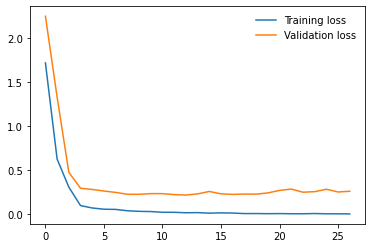

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
# track test loss
test_loss     = 0.0
class_correct = [0]*2
class_total   = [0]*2

model.eval()

# For generating confusion matrix
conf_matrix = np.zeros((2,2))

# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data   = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        # Update confusion matrix
        conf_matrix[label][pred.data[i]] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.051572

Test Accuracy of   0: 87% (164/188)
Test Accuracy of   1: 93% (225/240)

Test Accuracy (Overall): 90% (389/428)


Testing

In [ ]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=torch.load('/content/drive/MyDrive/Monkeypox-cse499/monkeypox.pth' )
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    input= image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

MonkeyPox


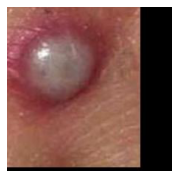

In [ ]:
from PIL import Image


img = Image.open('/content/drive/MyDrive/Monkeypox-cse499/Fold1/Val/Monkeypox/M17_01_03.jpg')
to_pil = transforms.ToPILImage()
images = test_transforms(img)
fig=plt.figure(figsize=(10,10))
classes = ['MonkeyPox', 'Others']
image = to_pil(images)
index = predict_image(image)
sub = fig.add_subplot(1, len(images), 1)


pred=str(classes[index])
sub.set_title(print(pred))
plt.axis('off')
plt.imshow(image)

plt.show()

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)

app.config['IMAGE_UPLOADS'] = "/content/drive/MyDrive/Colab Notebooks/temp_file"

from werkzeug.utils import secure_filename

@app.route("/",methods=['POST',"GET"])
@app.route("/home",methods=['POST',"GET"])
def upload_image():
        if request.method == "POST":
                image = request.files['file']
                if image.filename == '':
                        print("File name is invalid")
                        return redirect(request.url)
                filename = secure_filename(image.filename)

                #basedir = os.path.abspath(os.path.dirname(_file_))
                filesource = str((app.config['IMAGE_UPLOADS'])+"/"+filename)
                image.save(os.path.join(app.config['IMAGE_UPLOADS'],filename))
                img = Image.open(filesource)
                data = io.BytesIO()
                img.save(data,"JPEG")
                encoded_img_data = base64.b64encode(data.getvalue())
                to_pil = transforms.ToPILImage()
                images = test_transforms(img)
                fig=plt.figure(figsize=(10,10))
                classes = ['MonkeyPox', 'Others']
                image = to_pil(images)
                index = predict_image(image)
                sub = fig.add_subplot(1, len(images), 1)
                pred=str(classes[index])
                dir = "/content/drive/MyDrive/Colab Notebooks/temp_file"
                return render_template("index.html",filename=filename, pred=pred, display="none", img_data=encoded_img_data.decode('utf-8'))
        return render_template("index.html")

@app.route('/display/<filename>')
def display_image(filename):
        return redirect('static',pred = pred,code=301)


app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://2e64-35-231-131-169.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:15] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:16] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:16] "GET /static/uploader.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:16] "GET /static/responsive.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/animate.min.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/normalize.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/icomoon.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/css/font-awesome.min.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/meanmenu.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/owl.carousel.min.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jan/2023 09:32:19] "GET /static/swip